In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [23]:
# Load the data
crew_df = pd.read_csv("/Users/zhaochenfei/Desktop/data_visualization/title.crew.tsv", sep='\t', na_values='\\N')
ratings_df = pd.read_csv("/Users/zhaochenfei/Desktop/data_visualization/title.ratings.tsv", sep='\t', na_values='\\N')
basics_df = pd.read_csv("/Users/zhaochenfei/Desktop/data_visualization/title.basics.tsv", sep='\t', na_values='\\N')

/var/folders/s0/jfrnd8d957b78kvwgnwqdsjm0000gn/T/ipykernel_2186/3557121406.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  basics_df = pd.read_csv("/Users/zhaochenfei/Desktop/data_visualization/title.basics.tsv", sep='\t', na_values='\\N')


# Data Processing

In [24]:
# Filter out movie data
movies_df = basics_df[(basics_df['titleType'] == 'movie') & (basics_df['startYear'] != '\\N')].copy()
movies_df['startYear'] = pd.to_numeric(movies_df['startYear'], errors='coerce')  # Convert to numeric
movies_df.dropna(subset=['startYear'], inplace=True)
movies_df['startYear'] = movies_df['startYear'].astype(int)

# Merge ratings data with movie data
movies_ratings = movies_df.merge(ratings_df[['tconst', 'averageRating', 'numVotes']], on='tconst', how='inner')

# Merge with crew data to add directors information
movies_ratings = movies_ratings.merge(crew_df[['tconst', 'directors']], on='tconst', how='left')

# Handle missing values
movies_ratings['averageRating'].fillna(movies_ratings['averageRating'].median(), inplace=True)
movies_ratings.dropna(subset=['genres'], inplace=True)

# Standardize formats
movies_ratings['averageRating'] = movies_ratings['averageRating'].astype(float)
movies_ratings['numVotes'] = movies_ratings['numVotes'].astype(int)

# Remove duplicates
movies_ratings.drop_duplicates(subset=['tconst'], inplace=True)

# Exclude movies with fewer than 10,000 ratings
movies_ratings = movies_ratings[movies_ratings['numVotes'] >= 10000]

# Ensure 'directors' column values are strings and split
movies_ratings['directors'] = movies_ratings['directors'].astype(str).str.split(',')

# Explode the 'directors' column for separate rows per director
movies_exploded = movies_ratings.explode('directors')

# Calculate each director's first movie year
director_first_year = movies_exploded.groupby('directors')['startYear'].min().reset_index()
director_first_year.columns = ['directors', 'first_year']

# Merge back with exploded data to get each movie's director experience
movies_exploded = movies_exploded.merge(director_first_year, on='directors', how='left')
movies_exploded['director_experience'] = movies_exploded['startYear'] - movies_exploded['first_year']

# Group by director to calculate average rating and experience
director_stats = movies_exploded.groupby('directors').agg(
    director_experience=('director_experience', 'max'),
    avg_rating=('averageRating', 'mean')
).reset_index()

/var/folders/s0/jfrnd8d957b78kvwgnwqdsjm0000gn/T/ipykernel_2186/1333164157.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_ratings['averageRating'].fillna(movies_ratings['averageRating'].median(), inplace=True)


# Visualization

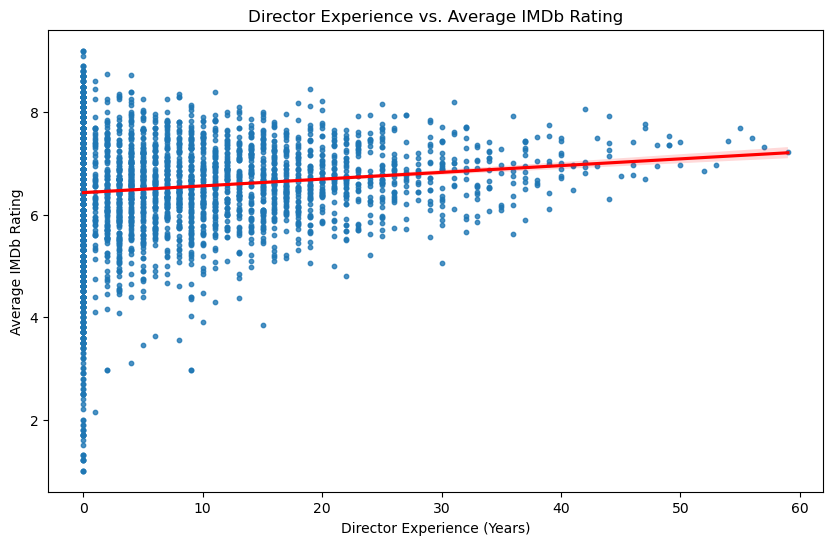

In [25]:
# Plot scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=director_stats, x='director_experience', y='avg_rating', scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Director Experience vs. Average IMDb Rating')
plt.xlabel('Director Experience (Years)')
plt.ylabel('Average IMDb Rating')
plt.show()

The graph suggests that there is a minor positive correlation between a director's experience and the average IMDb rating of their films, meaning experienced directors might tend to make slightly higher-rated movies. However, the relationship is weak, indicating that experience alone is not a strong determinant of movie ratings. This result suggests that other factors beyond experience, such as genre, or production quality, may play a more significant role in determining a film's success on IMDb.

/Users/zhaochenfei/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhaochenfei/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhaochenfei/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/zhaochenfei/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

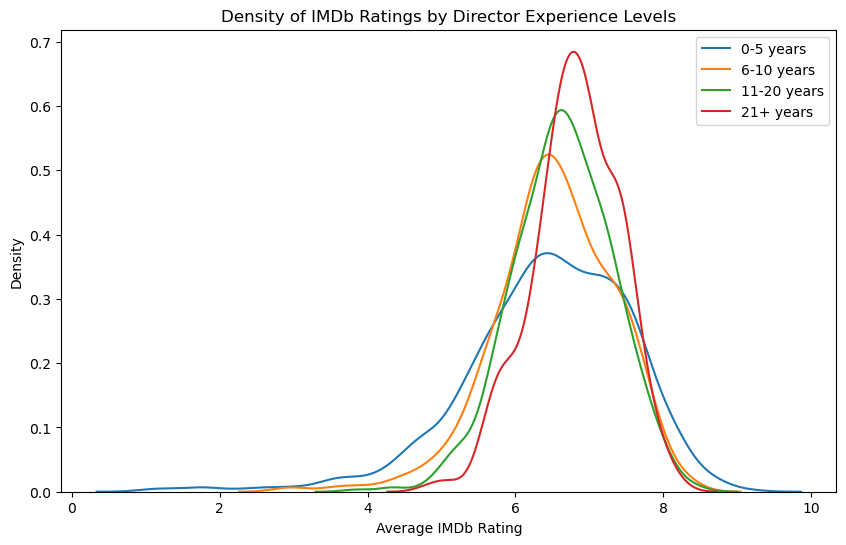

In [26]:
# Plot density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=director_stats[director_stats['director_experience'] <= 5]['avg_rating'], label='0-5 years')
sns.kdeplot(data=director_stats[(director_stats['director_experience'] > 5) & (director_stats['director_experience'] <= 10)]['avg_rating'], label='6-10 years')
sns.kdeplot(data=director_stats[(director_stats['director_experience'] > 10) & (director_stats['director_experience'] <= 20)]['avg_rating'], label='11-20 years')
sns.kdeplot(data=director_stats[director_stats['director_experience'] > 20]['avg_rating'], label='21+ years')
plt.title('Density of IMDb Ratings by Director Experience Levels')
plt.xlabel('Average IMDb Rating')
plt.ylabel('Density')
plt.legend()
plt.show()

In the density plot that visualizes the distribution of IMDb ratings across different levels of director experience, each curve represents a specific experience range.
More experienced directors (21+ years) are more likely to produce movies with higher ratings, as shown by the concentration around higher IMDb scores.Less experienced directors (0-5 years) show greater variability, producing both high and low-rated movies, indicating less consistency in rating outcomes.Overall, the plot reinforces the idea that experience may contribute to higher and more consistent IMDb ratings, but the effect is gradual rather than dramatic.